In [1]:
import os
import sys

def add_to_sys_path(relative_path):
    abs_path = os.path.abspath(os.path.join(os.getcwd(), relative_path))
    if abs_path not in sys.path:
        sys.path.append(abs_path)

add_to_sys_path(os.path.join('..', '..', '..', 'Utils'))
add_to_sys_path(os.path.join('..', '..', '..', 'Model'))
add_to_sys_path(os.path.join('..', '..', '..', 'Biased Sampling'))

In [2]:
import pandas as pd

from LR import base_model as base_model_call
from model_data_processing import Data_Handler, Model_Metrics_Visualizer
from stealthy_sampling import *

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
data = pd.read_csv('../../../Dataset/cybersecurity_intrusion_data.csv')
# data = data.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'uid', 'originh', 'responh'])
data = data.dropna(axis=0)
data.head()

,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected
0,SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,1
1,SID_00002,472,TCP,3,1557.996461,DES,0.301569,0,Firefox,0,0
2,SID_00003,629,TCP,3,75.044262,DES,0.739164,2,Chrome,0,1
3,SID_00004,804,UDP,4,601.248835,DES,0.123267,0,Unknown,0,1
4,SID_00005,453,TCP,5,532.540888,AES,0.054874,1,Firefox,0,0


In [4]:
has_failed_logins = []
for i in data['failed_logins']:
    if i:
        has_failed_logins.append(1)
    else:
        has_failed_logins.append(0)

data['has_failed_logins'] = has_failed_logins

In [5]:
# data['encryption_used'].value_counts()
print(data[data['attack_detected']==0]['encryption_used'].value_counts())
print(data[data['attack_detected']==1]['encryption_used'].value_counts())

encryption_used
AES    2651
DES    1566
Name: count, dtype: int64
encryption_used
AES    2055
DES    1299
Name: count, dtype: int64


In [6]:
data['protocol_type'] = data['protocol_type'].replace({'ICMP': 0, 'TCP': 1, 'UDP': 2})
data['encryption_used'] = data['encryption_used'].replace({'AES': 0, 'DES': 1})

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


In [7]:
data['encryption_used'].value_counts()

encryption_used
0    4706
1    2865
Name: count, dtype: int64

In [8]:
binary_columns = []
for col in data.columns:
    if len(data[col].unique())==2:
        binary_columns.append(col)

print("Binary columns:", binary_columns)

Binary columns: ['encryption_used', 'unusual_time_access', 'attack_detected', 'has_failed_logins']


In [9]:
data['attack_detected'] = data['attack_detected'].replace({0: 1, 1: 0})

In [10]:
data = data.drop(data.select_dtypes(include='object').columns, axis=1)
# print(data[data['Label']==0]['binary_flow_duration'].value_counts())
# print(data[data['Label']==1]['binary_flow_duration'].value_counts())
data.head()

,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,unusual_time_access,attack_detected,has_failed_logins
0,599,1,4,492.983263,1,0.606818,1,0,0,1
1,472,1,3,1557.996461,1,0.301569,0,0,1,0
2,629,1,3,75.044262,1,0.739164,2,0,0,1
3,804,2,4,601.248835,1,0.123267,0,0,0,0
4,453,1,5,532.540888,0,0.054874,1,0,1,1


In [11]:
protected_feature='has_failed_logins'
superior_outcome_value = 1

In [12]:
data[protected_feature].value_counts()

has_failed_logins
1    6318
0    1253
Name: count, dtype: int64

In [13]:
x_train, x_test, y_train, y_test, feature_names, scaler = Data_Handler(
        df=data,
        target_column='attack_detected',
        protected_feature=protected_feature,
        do_scaling=True,
        correlation_threshold=0.35,
        test_size=0.3,
        random_state=0
    )


Applying feature correlation removal...
Scaling only continuous numerical features (excluding heuristic categoricals and protected feature by default).
Features actually being scaled: ['network_packet_size', 'login_attempts', 'session_duration', 'ip_reputation_score', 'failed_logins']


In [14]:
print(len(x_train.columns))
x_train.head()

9


,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,unusual_time_access,has_failed_logins
329,0.641523,1,-0.008067,-0.658012,1,3.037881,1.433733,0,1
2228,-1.880106,1,-1.025828,-0.113858,0,-0.044663,-1.468234,1,0
3053,-0.783526,1,1.518575,-0.430023,0,-1.407127,0.466410,0,1
6881,-0.035628,1,-0.516947,0.337109,0,1.161365,-0.500912,0,1
1682,-0.904807,1,0.500814,0.643023,0,0.518451,0.466410,0,1


Accuracy: 0.7579225352112676
Precision: 0.7578178143941044
Recall: 0.7579225352112676
F-1: 0.7561830391828036


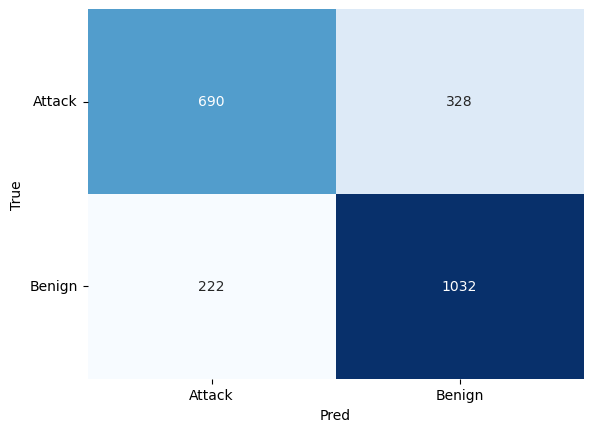

In [15]:
model = base_model_call(x_train, y_train, protected_feature, True)
y_pred = model.predict(x_test)
Model_Metrics_Visualizer(y_test, y_pred)

In [16]:
# Pass the DataFrame to the attacker class to maintain feature names for plotting
attacker = AdversarialSHAPBackgroundAttack(
        model=model,
        X_train=x_train,
        sensitive_feature_name=protected_feature,
        sensitive_feature_index=list(x_train.columns).index(protected_feature),
        explainer_type='linear',
        background_size=200,
        lambda_reg=1e-4,
        gamma_entropy=1e-7
    )

Running attack with LinearExplainer...
[Before] Mean SHAP per feature:
[-1.37826555e-03 -5.31833909e-04 -3.33205638e-02  1.23057027e-03
 -1.11022302e-18 -8.53896384e-03 -1.01030159e-01 -2.39324196e-03
  1.15463195e-16]
Weight stats: min=0.0049999999100216064, max=0.005000000019751384, mean=0.005000000000000024
[After] Mean SHAP per feature:
[-0.00030792 -0.00106367 -0.00980017  0.00180727  0.00347282 -0.08666608
  0.04329864 -0.00430784  0.03903859]


Converting A to a CSC (compressed sparse column) matrix; may take a while.
Converting P to a CSC (compressed sparse column) matrix; may take a while.


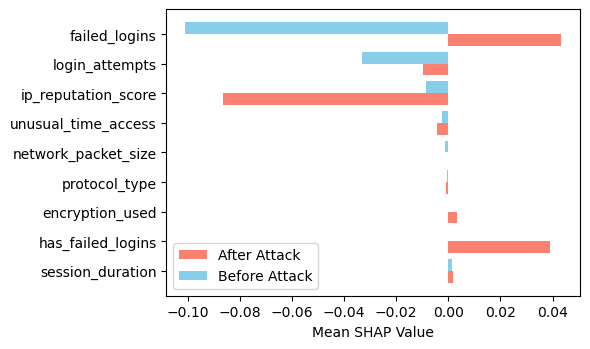

In [17]:
biased_weights, before, after = attacker.run_attack()
attacker.plot_shap_comparison(before, after)

In [19]:
print(f"Sensitive feature '{protected_feature}' importance before attack: {before[attacker.sensitive_feature_index]:.4f}")
print(f"Sensitive feature '{protected_feature}' importance after attack: {after[attacker.sensitive_feature_index]:.4f}")
    
change = after[attacker.sensitive_feature_index] - before[attacker.sensitive_feature_index]
pct_change = (change / before[attacker.sensitive_feature_index] * 100) if before[attacker.sensitive_feature_index] != 0 else float('inf')
print(f"Change in importance: {change:.4f} ({pct_change:.2f}%)")

Sensitive feature 'has_failed_logins' importance before attack: 0.0000
Sensitive feature 'has_failed_logins' importance after attack: 0.0390
Change in importance: 0.0390 (33810417031121992.00%)
